# Neural Modelling: Assignment 4
## Model fitting and Pavlovian biases
### Submission Group: Luca Kosina (6084778), Sascha Mühlinghaus (7075485)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import softmax
from tqdm import tqdm
import time

In [26]:
df = pd.read_csv('gen_data.csv', index_col=0)
cue_mapping = {1: 'Go+', 2: 'Go-', 3: 'NoGo+', 4: 'NoGo-'}  # Go+ = Go to win, Go- = go to avoid losing, NoGo+ = don't go to win, NoGo- = don't go to avoid losing

### Exercise 1: Plot the accuracy for each given cue

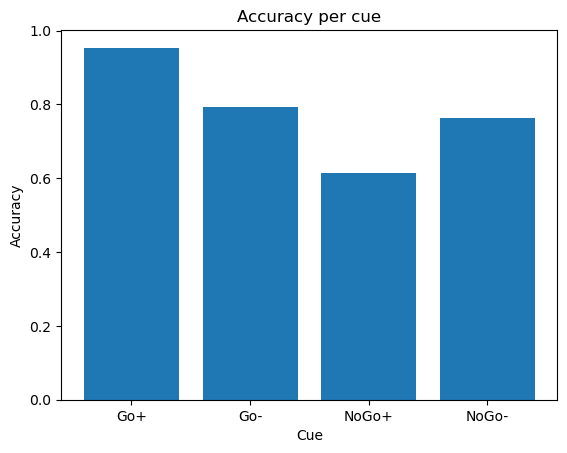

In [27]:
cue_mapping = {1: 'Go+', 2: 'Go-', 3: 'NoGo+', 4: 'NoGo-'}
df['cue_name'] = df['cue'].map(cue_mapping)

# define correct response for each cue
correct_criteria = {
    'Go+': 1,    
    'Go-': 1,    
    'NoGo+': 0,  
    'NoGo-': 0   
}

# calculate accuracy for each cue
accuracies = {}
for cue in cue_mapping:
    cue_name = cue_mapping[cue]
    subset = df[df['cue'] == cue]
    correct_response = correct_criteria[cue_name]
    accuracies[cue_name] = (subset['pressed'] == correct_response).mean()

# plot the accuracies per cue 
plt.bar(accuracies.keys(), accuracies.values())
plt.xlabel('Cue')
plt.ylabel('Accuracy')
plt.title('Accuracy per cue')
plt.show()

The figure shows the performance in a task with 4 conditions of 10 subjects, the task was performed by subjects in Dolan et al. (2012). Here, we reproduce their results with the gen_data.csv dataset. In the Go+ condition the subjects need to press a button to obtain a reward, in the Go- task the subjects need to press the button to not obtain a punishment, in the NoGo+ task the subjects need to not press to obtain a reward and in NoGo+ the subjects need to not press to not obtain a pusnishment. Each condition is indicated by a distinct stimulus at the beginning of the trial. We observe that the average performance of the subjects is the highest in the Go+ task, followed by the Go- and NoGo- conditions with around 0.78 and NoGo+ around 0.62. The performance is explained by the action/valence paradigm. Rewards are associated with approach and and punishment with withdrawel, thereby some conditions are mure intuitive to the subjects than others.

### Exercise 2: Fitting models to task behaviour of subjects

In [28]:
# create function to add a bias to a copy of the q-value
def add_bias(q_value_current, bias_app, bias_wth):
    q_value_current[0] += bias_wth
    q_value_current[1] += bias_app
    return q_value_current

In [29]:
def model_1(data, epsilon, beta):
    # initialize the log likelihood, q-values and probabilities
    log_likelihood = 0
    q = np.zeros(8)
    probabilities = np.zeros(len(data))

    for i in range(len(data)):
        # get cue, reward and action value from the data
        cue, action, reward = data.iloc[i][:3]
        # get the index for the current q-value
        q_index = (cue-1) * 2 + action
        # update the q-value
        q[q_index] = q[q_index] + epsilon * (beta*reward - q[q_index])
        # get the current q-values
        q_values_current = q[(cue-1) * 2 : (cue-1) * 2 + 2]
        # compute the softmax probability of the current q-values 
        # and save to the probabilities array
        probabilities[i] = softmax(q_values_current)[action]
    # compute the log likelihood for all the probabilities
    log_likelihood = np.sum(np.log(probabilities))
    return -log_likelihood

In [30]:
def model_2(data, epsilon, p_rew, p_pun):
    # initialize the log likelihood, q-values and probabilities
    log_likelihood = 0
    q = np.zeros(8) # 4 * 2 q-values for each cue-action pair
    probabilities = np.zeros(len(data))

    for i in range(len(data)):
        # get cue, reward and action value from the data
        cue, action, reward = data.iloc[i][:3]
        # depending on the reward, set the beta value
        if reward == 1:
            beta =  p_rew
        elif reward == 0:
            beta =  0
        elif reward == -1:
            beta = p_pun
        # get the index for the current q-value
        q_index = (cue-1) * 2 + action
        # update the q-value
        q[q_index] = q[q_index] + epsilon * (beta*reward - q[q_index])
        # get the current q-values
        q_values_current = q[(cue-1) * 2 : (cue-1) * 2 + 2]
        # compute the softmax probability of the current q-values 
        # and save to the probabilities array
        probabilities[i] = softmax(q_values_current)[action]
    # compute the log likelihood for all the probabilities
    log_likelihood = np.sum(np.log(probabilities))
    return -log_likelihood

In [31]:
def model_3(data, beta, learning_rate_rew, learning_rate_pun, learning_rate_obm):
    # initialize the log likelihood, q-values and probabilities
    log_likelihood = 0
    q = np.zeros(8) # 4 * 2 q-values for each cue-action pair
    probabilities = np.zeros(len(data))

    for i in range(len(data)):
        # get cue, reward and action value from the data
        cue, action, reward = data.iloc[i][:3]
        # depending on the reward, set the epsilon value
        if reward == 1:
            epsilon = learning_rate_rew
        elif reward == 0:
            epsilon = learning_rate_obm
        elif reward == -1:
            epsilon = learning_rate_pun
        # get the index for the current q-value
        q_index = (cue-1) * 2 + action
        # update the q-value
        q[q_index] = q[q_index] + epsilon * (beta*reward - q[q_index])
        # get the current q-values
        q_values_current = q[(cue-1) * 2 : (cue-1) * 2 + 2]
        # compute the softmax probability of the current q-values 
        # and save to the probabilities array
        probabilities[i] = softmax(q_values_current)[action]
    # compute the log likelihood for all the probabilities
    log_likelihood = np.sum(np.log(probabilities))
    return -log_likelihood

In [32]:
def model_4(data, epsilon, beta, bias_app, bias_wth):
    # initialize the log likelihood, q-values and probabilities
    log_likelihood = 0
    q = np.zeros(8) # 4 * 2 q-values for each cue-action pair
    probabilities = np.zeros(len(data))

    for i in range(len(data)):
        # get cue, reward and action value from the data
        cue, action, reward = data.iloc[i][:3]
        # get the index for the current q-value
        q_index = (cue-1) * 2 + action
        # get the current q-values
        q_values_current = q[(cue-1) * 2 : (cue-1) * 2 + 2]
        # add the bias to a copy of the q-value
        q_values_current = add_bias(q_values_current, bias_app, bias_wth)
        # compute the softmax probability of the current q-values 
        # and save to the probabilities array
        probabilities[i] = softmax(q_values_current)[action]
        # update the q-value
        q[q_index] = q[q_index] + epsilon * (beta*reward - q[q_index])
    # compute the log likelihood for all the probabilities
    log_likelihood = np.sum(np.log(probabilities))
    return -log_likelihood

In [33]:
def model_5(data, epsilon, p_rew, p_pun, bias_app, bias_wth):
    # initialize the log likelihood, q-values and probabilities
    log_likelihood = 0
    q = np.zeros(8) # 4 * 2 q-values for each cue-action pair
    probabilities = np.zeros(len(data))

    for i in range(len(data)):
        # get cue, reward and action value from the data
        cue, action, reward = data.iloc[i][:3]
        # depending on the reward, set the beta value
        if reward == 1:
            beta = p_rew
        elif reward == 0:
            beta = 0
        elif reward == -1:
            beta = p_pun
        # get the index for the current q-value
        q_index = (cue-1) * 2 + action
        # get the current q-values
        q_values_current = q[(cue-1) * 2 : (cue-1) * 2 + 2]
        # add the bias to a copy of the q-value
        q_values_current = add_bias(q_values_current, bias_app, bias_wth)
        # compute the softmax probability of the current q-values 
        # and save to the probabilities array
        probabilities[i] = softmax(q_values_current)[action]
        # update the q-value
        q[q_index] = q[q_index] + epsilon * (beta*reward - q[q_index])
    # compute the log likelihood for all the probabilities
    log_likelihood = np.sum(np.log(probabilities))
    return -log_likelihood

In [34]:
def model_6(data, epsilon, p_app_rew, p_app_pun, p_wth_rew, p_wth_pun, bias_app, bias_wth):
    # initialize the log likelihood, q-values and probabilities
    log_likelihood = 0
    q = np.zeros(8) # 4 * 2 q-values for each cue-action pair
    probabilities = np.zeros(len(data))

    for i in range(len(data)):
        # get cue, reward and action value from the data
        cue, action, reward = data.iloc[i][:3]
        # depending on the reward and action, set the beta value
        if reward == 0:
            beta = 0
        elif reward == 1 and action == 1:
            beta = p_app_rew
        elif reward == -1 and action == 1:
            beta = p_app_pun
        elif reward == 1 and action == 0:
            beta = p_wth_rew
        elif reward == -1 and action == 0:
            beta = p_wth_pun

        # get the index for the current q-value
        q_index = (cue-1) * 2 + action
        # get the current q-values
        q_values_current = q[(cue-1) * 2 : (cue-1) * 2 + 2]
        # add the bias to a copy of the q-value
        q_values_current = add_bias(q_values_current, bias_app, bias_wth)
        # compute the softmax probability of the current q-values 
        # and save to the probabilities array
        probabilities[i] = softmax(q_values_current)[action]
        # update the q-value
        q[q_index] = q[q_index] + epsilon * (beta*reward - q[q_index])
    # compute the log likelihood for all the probabilities
    log_likelihood = np.sum(np.log(probabilities))
    return -log_likelihood

In [35]:
def model_7(data, learning_rate_app, learning_rate_wth, p_rew, p_pun, bias_app, bias_wth):
    # initialize the log likelihood, q-values and probabilities
    log_likelihood = 0
    q = np.zeros(8) # 4 * 2 q-values for each cue-action pair
    probabilities = np.zeros(len(data))
    
    for i in range(len(data)):
        # get cue, reward and action value from the data
        cue, action, reward = data.iloc[i][:3]
        # depending on the reward, set the beta value
        if reward == 1:
            beta = p_rew
        elif reward == 0:
            beta = 0
        elif reward == -1:
            beta = p_pun
        # depending on the action, set the epsilon value
        if action == 1:
            epsilon = learning_rate_app
        elif action == 0:
            epsilon = learning_rate_wth
        # get the index for the current q-value
        q_index = (cue-1) * 2 + action
        # get the current q-values
        q_values_current = q[(cue-1) * 2 : (cue-1) * 2 + 2]
        # add the bias to a copy of the q-value
        q_values_current = add_bias(q_values_current, bias_app, bias_wth)
        # compute the softmax probability of the current q-values 
        # and save to the probabilities array
        probabilities[i] = softmax(q_values_current)[action]
        # update the q-value
        q[q_index] = q[q_index] + epsilon * (beta*reward - q[q_index])
    # compute the log likelihood for all the probabilities
    log_likelihood = np.sum(np.log(probabilities))
    return -log_likelihood

In [36]:
def model_8(data, learning_rate_app, learning_rate_wth, p_rew, p_pun, bias_app, bias_wth, p):
    # initialize the log likelihood, q-values and probabilities
    log_likelihood = 0
    q = np.zeros(8) # 4 * 2 q-values for each cue-action pair
    probabilities = np.zeros(len(data))

    for i in range(len(data)):
        # get cue, reward and action value from the data
        cue, action, reward = data.iloc[i][:3]
        # depending on the reward, set the beta value
        if reward == 1:
            beta = p_rew
        elif reward == 0:
            beta = 0
        elif reward == -1:
            beta = p_pun
        # depending on the action, set the epsilon value
        if action == 1:
            epsilon = learning_rate_app
        elif action == 0:
            epsilon = learning_rate_wth
        # get the index for the current q-value
        q_index = (cue-1) * 2 + action
        # get the current q-values
        q_values_current = q[(cue-1) * 2 : (cue-1) * 2 + 2]
        # add the bias to a copy of the q-value
        q_values_copy = add_bias(q_values_current, bias_app, bias_wth)
        # add p to the q-values 
        if np.max(q_values_current) > 0 and action == 1:
            q_values_copy[action] += p
        elif np.max(q_values_current) < 0 and action == 0:
            q_values_copy[action] += p
        # compute the softmax probability of the current q-values 
        # and save to the probabilities array
        probabilities[i] = softmax(q_values_copy)[action]
        # update the q-value
        q[q_index] = q[q_index] + epsilon * (beta*reward - q[q_index])
    # compute the log likelihood for all the probabilities
    log_likelihood = np.sum(np.log(probabilities))
    return -log_likelihood

Training model_1...


10it [01:16,  7.63s/it]

Model: model_1
Summed Log Likelihood: -2882.033846076703
BIC: 5776.861551463839
Fitted Parameters: [0.32614596 2.24649658]
Time Taken: 76.31 seconds


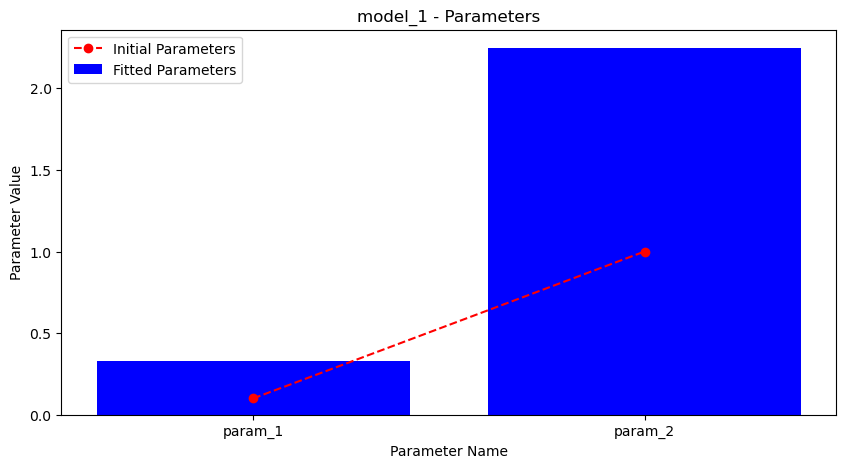

Training model_2...


10it [02:12, 13.25s/it]

Model: model_2
Summed Log Likelihood: -2877.7773883194723
BIC: 5774.745565604593
Fitted Parameters: [0.32231917 2.1158265  2.36367438]
Time Taken: 132.50 seconds


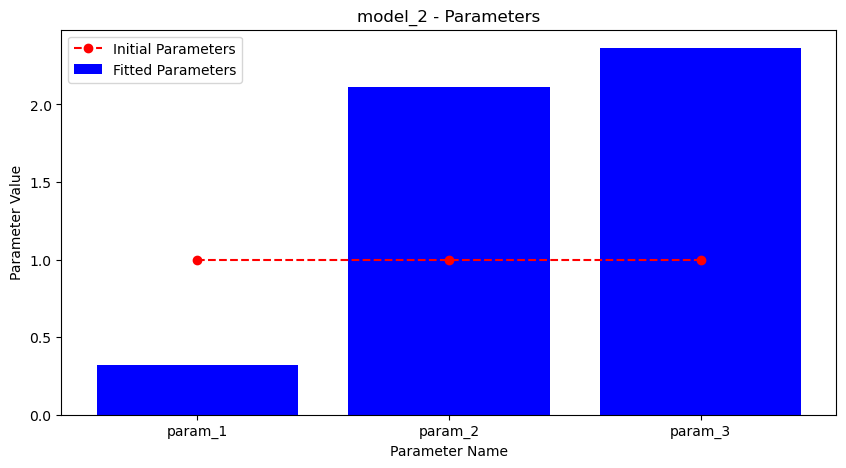

Training model_3...


10it [03:09, 18.90s/it]

Model: model_3
Summed Log Likelihood: -2827.2608984262656
BIC: 5680.109515473396
Fitted Parameters: [2.63771841 0.62810408 0.23714389 0.1220516 ]
Time Taken: 189.03 seconds


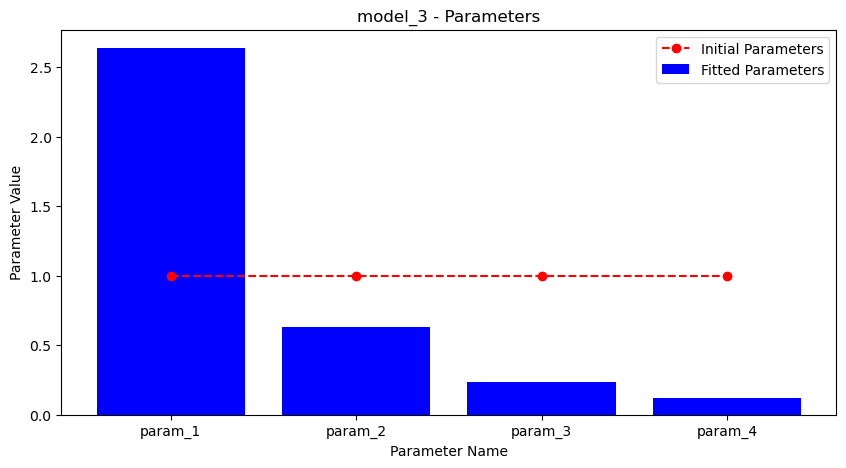

Training model_4...


10it [05:54, 35.46s/it]

Model: model_4
Summed Log Likelihood: -2726.0782007212856
BIC: 5477.744120063436
Fitted Parameters: [ 0.3098359   2.66222568  0.05868229 -0.00796395]
Time Taken: 354.56 seconds


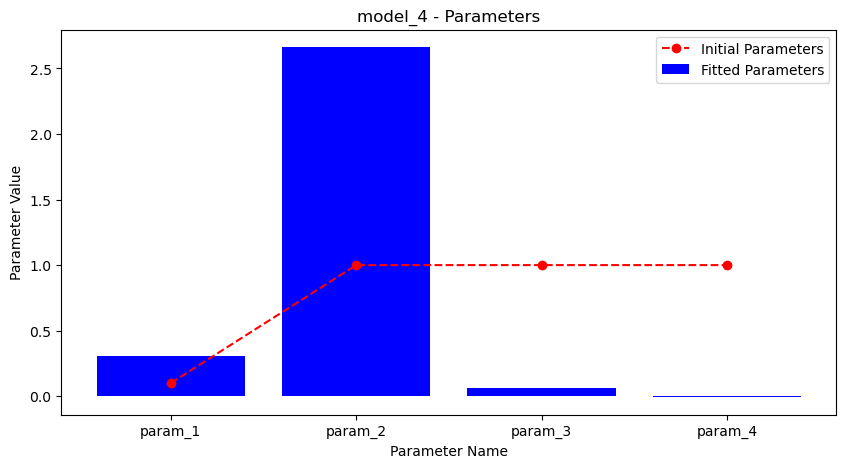

Training model_5...


10it [10:40, 64.02s/it]

Model: model_5
Summed Log Likelihood: -2717.7053802032997
BIC: 5467.39540868268
Fitted Parameters: [0.25235001 2.60038748 3.65517298 0.07919159 0.00659714]
Time Taken: 640.17 seconds


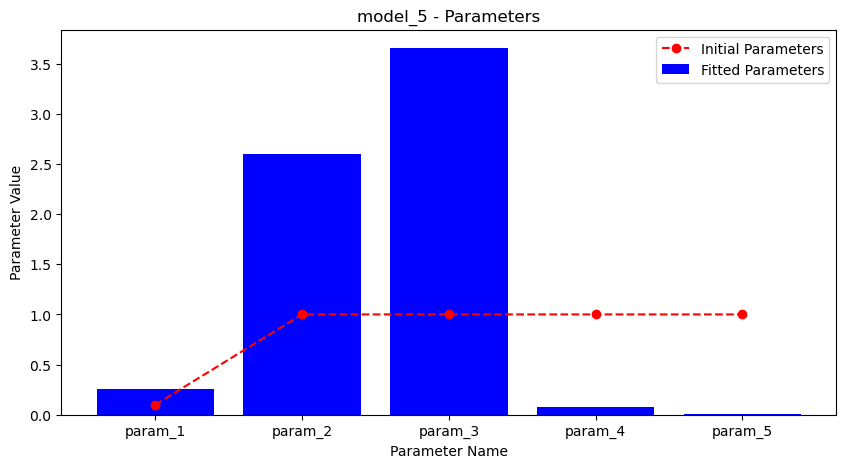

Training model_6...


10it [19:47, 118.76s/it]


Model: model_6
Summed Log Likelihood: -2699.607106029935
BIC: 5443.992719646383
Fitted Parameters: [ 0.15042487  2.48820602  1.10584445  0.31424402  2.77000424 -0.03300073
 -0.00731393]
Time Taken: 1187.62 seconds


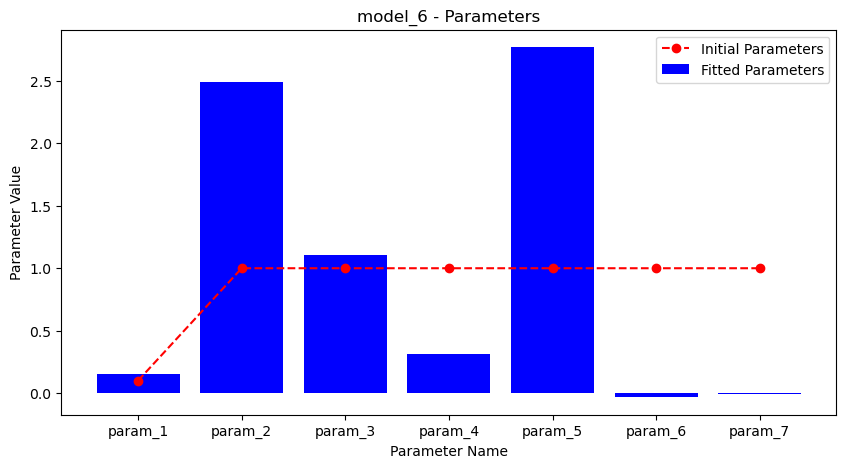

Training model_7...


10it [15:13, 91.38s/it]

Model: model_7
Summed Log Likelihood: -2801.88960336509
BIC: 5642.160784661477
Fitted Parameters: [ 0.64203342  0.22074709  0.70499088  1.50366299 -0.03235124 -0.04002531]
Time Taken: 913.81 seconds


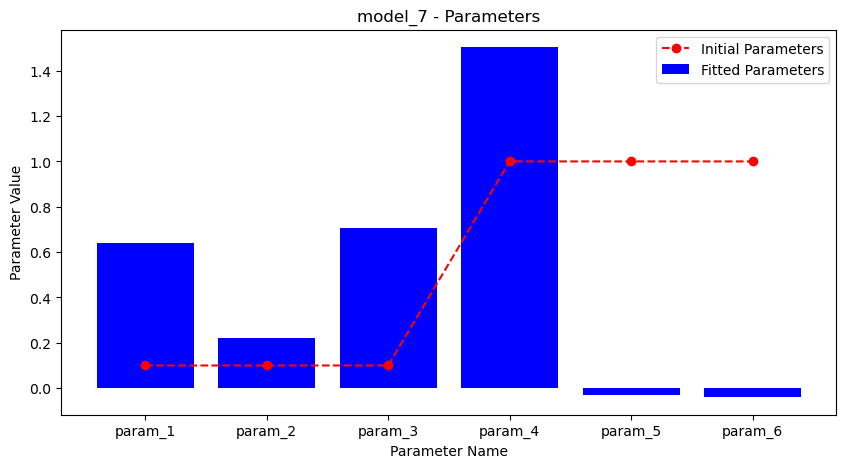

Training model_8...


10it [16:41, 100.13s/it]


Model: model_8
Summed Log Likelihood: -2577.2955130620667
BIC: 5199.3695337106465
Fitted Parameters: [ 6.01885432e-01  1.45657536e-01  7.82809064e-03  3.61887411e+00
 -9.72508549e-01  2.22765491e-01  8.53880881e+00]
Time Taken: 1001.27 seconds


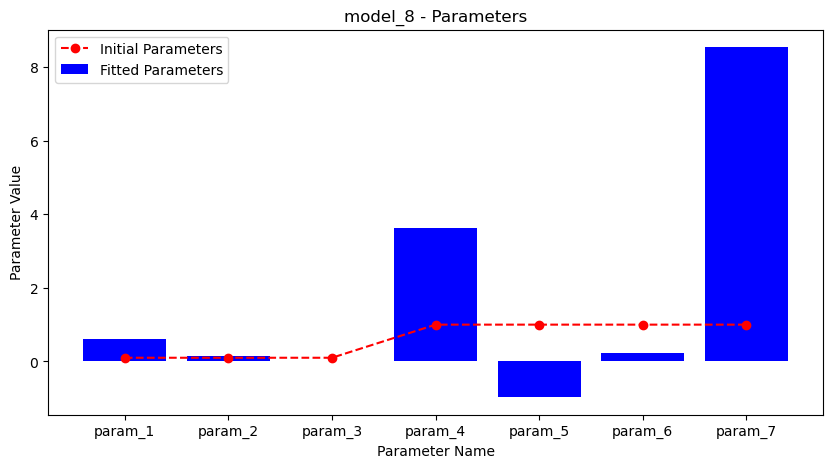

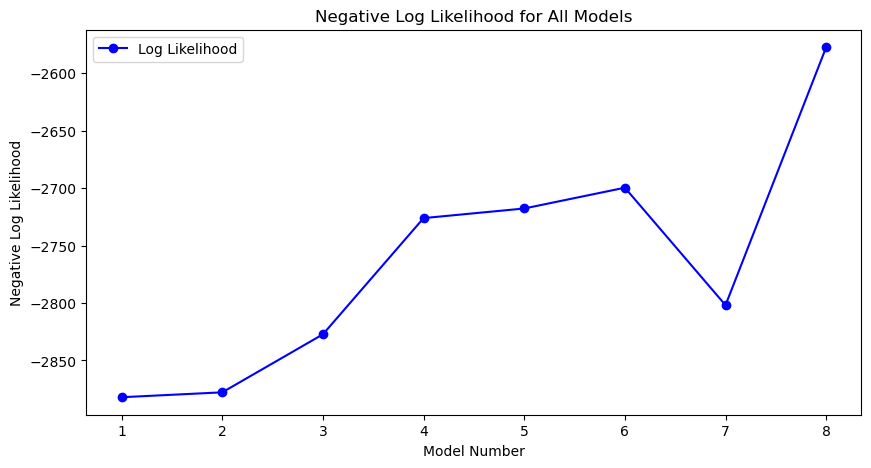

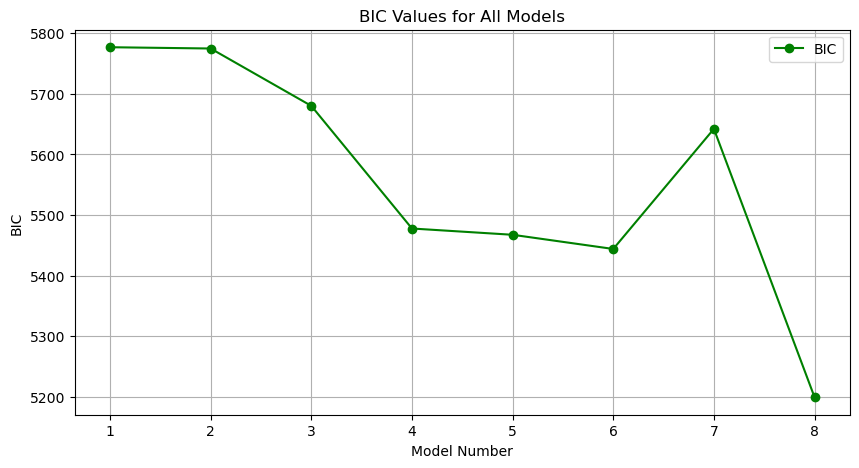

In [38]:
# define a function to compute the BIC
def BIC(data, log_likelihood, k):
    return k * np.log(len(data)) - 2 * log_likelihood

# dictionary to store model parameters
model_params = {}

# list to store BIC values for plotting at the end
bic_values = []
log_likelihoods = []

# loop over all models
for i in range(1, 9):
    learner_name = f"model_{i}" 
    print(f"Training {learner_name}...")

    # retrieve the learner function
    learner = globals()[learner_name] 
    if learner_name == 'model_1':
        # epsilon, beta
        initial_params = 0.1, 1
        bounds = [(0, 1), (0, 100)] 
    elif learner_name == 'model_2':
        # epsilon, p_rew, p_pun 
        initial_params = 1, 1, 1
        bounds = [(0, 1), (0, 100), (0, 100)]
    elif learner_name == 'model_3':
        # beta, learning_rate_rew, learning_rate_pun, learning_rate_obm
        initial_params = 1, 1, 1, 1
        bounds = [(0, 100), (0, 1), (0, 1), (0, 1)] 
    elif learner_name == 'model_4':
        # epsilon, beta, bias_app, bias_wth
        initial_params = 0.1, 1, 1, 1
        bounds = [(0, 1), (0, 100), (-10, 10), (-10, 10)] 
    elif learner_name == 'model_5':
        # epsilon, p_rew, p_pun, bias_app, bias_wth
        initial_params = 0.1, 1, 1, 1, 1
        bounds = [(0, 1), (0, 100), (0, 100), (-10, 10), (-10, 10)] 
    elif learner_name == 'model_6':
        # epsilon, p_app_rew, p_app_pun, p_wth_rew, p_wth_pun, bias_app, bias_wth
        initial_params = 0.1, 1, 1, 1, 1, 1, 1
        bounds = [(0, 1), (0, 100), (0, 100), (0, 100), (-10, 10), (-10, 10), (-10, 10)] 
    elif learner_name == 'model_7':
        # learning_rate_app, learning_rate_wth, p_rew, p_pun, bias_app, bias_wth
        initial_params = 0.1, 0.1, 0.1, 1, 1, 1
        bounds = [(0, 1), (0, 1), (0, 100), (0, 100), (-10, 10), (-10, 10)]
    elif learner_name == 'model_8':
        # learning_rate_app, learning_rate_wth, p_rew, p_pun, bias_app, bias_wth, p
        initial_params = 0.1, 0.1, 0.1, 1, 1, 1, 1
        bounds = [(0, 1), (0, 1), (0, 100), (0, 100), (-10, 10), (-10, 10), (-10, 10)]

    # initialize variables for the current model
    total_log_likelihood = 0
    start_time = time.time()

    # train model for each subject
    for k, subject in tqdm(enumerate(np.unique(df.ID))):
        subject_data = df[df['ID'] == subject].reset_index(drop=True)  # subset data to one subject

        # define the loss function
        def loss(params):
            return learner(subject_data, *params)

        # optimize model parameters
        res = minimize(loss, initial_params, bounds=bounds, method='Nelder-Mead')

        # accumulate log likelihood
        total_log_likelihood += -res.fun

        # store parameters
        model_params[(i, k)] = res.x

    # compute the BIC for the model
    N_params = len(initial_params)
    bic = BIC(subject_data, total_log_likelihood, N_params)
    bic_values.append(bic)
    log_likelihoods.append(total_log_likelihood)

    # print results for the current model
    print(f"Model: {learner_name}")
    print(f"Summed Log Likelihood: {total_log_likelihood}")
    print(f"BIC: {bic}")
    print(f"Fitted Parameters: {model_params[(i, k)]}")
    print(f"Time Taken: {time.time() - start_time:.2f} seconds")

    # plot fitted parameters vs initial parameters
    param_names = [f"param_{j+1}" for j in range(len(initial_params))]
    plt.figure(figsize=(10, 5))
    plt.bar(param_names, res.x, label='Fitted Parameters', color='blue')
    plt.plot(param_names, initial_params, marker='o', linestyle='--', color='red', label='Initial Parameters')
    plt.title(f"{learner_name} - Parameters")
    plt.ylabel("Parameter Value")
    plt.xlabel("Parameter Name")
    plt.legend()
    plt.show()

# plot the log likelihoods for all models
plt.figure(figsize=(10, 5))
plt.plot(range(1, 9), log_likelihoods, marker='o', color='blue', label='Log Likelihood')
plt.title("Negative Log Likelihood for All Models")
plt.ylabel("Negative Log Likelihood")
plt.xlabel("Model Number")
plt.xticks(range(1, 9))
plt.legend()


# plot BIC values for all models
plt.figure(figsize=(10, 5))
plt.plot(range(1, 9), bic_values, marker='o', color='green', label='BIC')
plt.title("BIC Values for All Models")
plt.ylabel("BIC")
plt.xlabel("Model Number")
plt.xticks(range(1, 9))
plt.legend()
plt.grid()
plt.show()

We started with a model with parameters not differentiating between reward and punishment trials, whereas Model 2 and 3 introduce different learning rates and betas for reward and punishment, respectively. Each additional parameter indicates small improvements in the fit indicated by the negative log likelihood.  

Model 4 adds a bias into the learning process, accounting for a subject's predisposition to approach or withhold responses regardless of feedback. Model 5 combines differentiated betas for reward and punishment with this bias, potentially improving its explanatory power. Model 6 further refines the framework by differentiating beta not only between reward and punishment but also between action and inhibition, enabling a more nuanced representation of feedback processing. Model 7 builds on this by also differentiating learning rates for action versus withholding, capturing potential asymmetries in learning dynamics based on response types. However, our results indicate that this does not improve the predictions of model 7.

Model 8 extends the framework by introducing a Pavlovian bias parameter that modulates action values based on valence (reward or punishment). This bias reflects tendencies to approach or withhold actions depending on whether the cue is associated with reward or punishment and including influences by both instrumental and Pavlovian factors.

Models with more parameters are expected to fit data better but at the cost of increased complexity. Therefore we expect the log likelihood to increase with each model. Bayesian Information Criterion (BIC) scores are computed to assess model performance. Lower BIC scores indicate better trade-offs between model complexity and data fit. The findings in the paper by Dolan et al. support this, with models having more parameters achieving lower BICs. 

We are not sure whether out models function correctly, yet the results seem to make sense and are close to the results shown in the tutorial chat. We had some trouble debugging because the fitting of the models took about 1 hour. We find that the negative log likelihoods increase strictly from Models 1–6, for model 7 the negative log likelihood decreases again. Indicating that the combination of adapting beta, epsilon and adding a instrumental bias is not omptimal to model the choices of the participants.
The model that describes the data best is the one with the lowest BIC which is in our case model 8.
Separate learning rates for rewards and punishments (Model 3) as well as separate reward and punishment sensitivities (Model 2) did not improve the performance substantially compared to models with biases (Model 4) and ones that additionally allowed separate reinforcement sensitivities (Model 6), or separate learning rates (Model 8) and with the pavlovian bias model performs best indicating that such biases play an important role in the learning of the given task.

Model: model_1   
Summed Log Likelihood: -2882.033846076703   
BIC: 5776.861551463839   
   
Model: model_2   
Summed Log Likelihood: -2877.7773883194723  
BIC: 5774.745565604593   
  
Model: model_3   
Summed Log Likelihood: -2827.2608984262656   
BIC: 5680.109515473396  
    
Model: model_4   
Summed Log Likelihood: -2726.0782007212856   
BIC: 5477.744120063436   

Model: model_5   
Summed Log Likelihood: -2717.7053802032997   
BIC: 5467.39540868268   

Model: model_6   
Summed Log Likelihood: -2699.607106029935   
BIC: 5443.992719646383   

Model: model_7    
Summed Log Likelihood: -2801.88960336509    
BIC: 5642.160784661477       
   
Model: model_8   
Summed Log Likelihood: -2577.2955130620667  
BIC: 5199.3695337106465  

### Compare the fitted ε-app and ε-wth for the last model. How do you interpret the difference in their means?

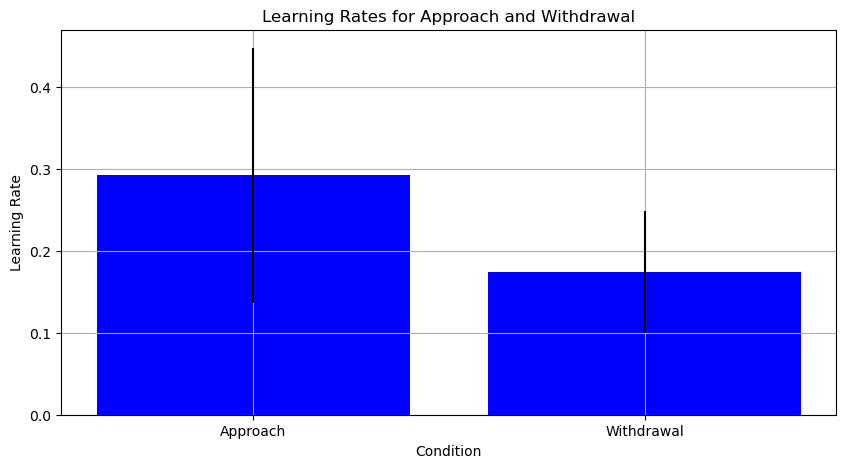

In [46]:
# get the fitted parameters for model 8
model_8_params = [model_params[(8, k)] for k in range(10)]

# get the fitted learning rates for approach and withdrawal
learning_rates = np.array(model_8_params)[:, :2]

# plot the learning rates for Approach and Withdrawal
plt.figure(figsize=(10, 5))
plt.bar(['Approach', 'Withdrawal'], learning_rates.mean(axis=0), yerr=learning_rates.std(axis=0), color='blue')
plt.title("Learning Rates for Approach and Withdrawal")
plt.ylabel("Learning Rate")
plt.xlabel("Condition")
plt.grid()
plt.show()

In Model 8, approach and withdrawal actions were intended to convey the same level of information. Nevertheless, subjects demonstrated a clear preference for approach actions over withdrawal actions. Across the group and in most individuals, approach actions had a greater impact, revealing a stronger bias and resulting in an imbalance in learning rates. This pattern indicates that subjects learned more efficiently from approach actions while showing less effectiveness in learning from withdrawal actions.

### Bonus Task: Fit with different initial parameters

100%|██████████| 10/10 [15:45<00:00, 94.50s/it] 


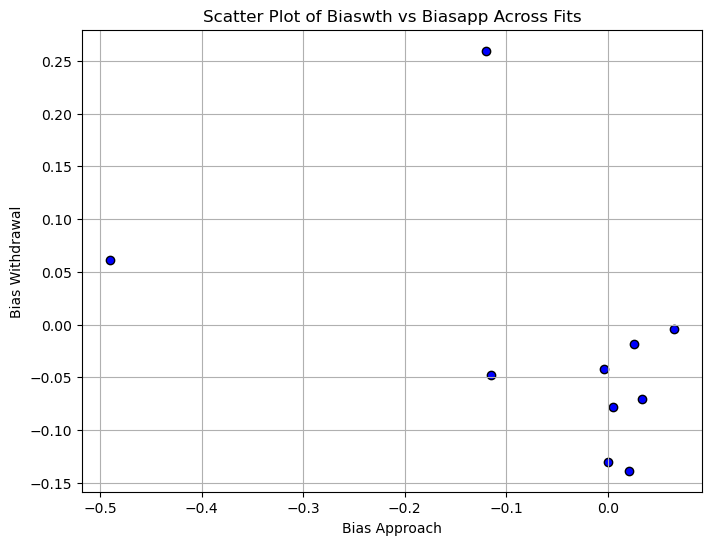

In [40]:
# define the function to compute the BIC (not used here, but included for context)
def BIC(data, log_likelihood, k):
    N = len(data)
    return k * np.log(N) - 2 * log_likelihood

# initialize parameters
subject_id = np.unique(df.ID)[0]  # get the first subject
subject_data = df[df['ID'] == subject_id].reset_index(drop=True)  # filter data for the first subject
# print(len(subject_data))

# initial parameters and bounds for Model 8
initial_param_sets = [np.random.uniform(0.1, 1, 7) for _ in range(10)]  # generate 10 sets of random initial params
bounds = [(0.01, 1), (0.01, 1), (0.01, 100), (0, 100), (-10, 10), (-10, 10), (-10, 10)]

# placeholders for fitted parameters
biasapp_values = []
biaswth_values = []

# loop through initial parameter sets
for initial_params in tqdm(initial_param_sets):
    # define the loss function
    def loss(params):
        return model_8(subject_data, *params)

    # optimize using the current set of initial parameters
    res = minimize(loss, initial_params, bounds=bounds, method='Nelder-Mead')

    # save biasapp (bias approach) and biaswth (bias withdrawal) values
    biasapp_values.append(res.x[4])  # index 4 corresponds to biasapp
    biaswth_values.append(res.x[5])  # index 5 corresponds to biaswth

# create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(biasapp_values, biaswth_values, color='blue', edgecolor='black')
plt.title("Scatter Plot of Biaswth vs Biasapp Across Fits")
plt.xlabel('Bias Approach')
plt.ylabel('Bias Withdrawal')
plt.grid(True)
plt.show()

### How do you explain this plot?

There is one main cluster with the withdrawal bias being within small negative values and the approach bias values being slightly positive. We do not believe that the results are meaningful because we cannot really make sense of it. The distribution of points suggests that the optimization procedure may converge to different local minima depending on the initial parameter values and the results might indicate that the log likelihood is sensitive to initialization. 